# Developing an AI application<a href="#Developing-an-AI-application" class="anchor-link">¶</a>

Going forward, AI algorithms will be incorporated into more and more
everyday applications. For example, you might want to include an image
classifier in a smart phone app. To do this, you'd use a deep learning
model trained on hundreds of thousands of images as part of the overall
application architecture. A large part of software development in the
future will be using these types of models as common parts of
applications.

In this project, you'll train an image classifier to recognize different
species of flowers. You can imagine using something like this in a phone
app that tells you the name of the flower your camera is looking at. In
practice you'd train this classifier, then export it for use in your
application. We'll be using [this
dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of
102 flower categories, you can see a few examples below.

<span class="image"></span>

The project is broken down into multiple steps:

-   Load and preprocess the image dataset
-   Train the image classifier on your dataset
-   Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can
be trained on any set of labeled images. Here your network will be
learning about flowers and end up as a command line application. But,
what you do with your new skills depends on your imagination and effort
in building a dataset. For example, imagine an app where you take a
picture of a car, it tells you what the make and model is, then looks up
information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to
keep all the imports at the beginning of your code. As you work through
this notebook and find you need to import a package, make sure to add
the import up here.

In \[ \]:

    # Imports here
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    from collections import OrderedDict

    import json


    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    import numpy as np

    from PIL import Image


    import torch
    from torch import nn
    from torch import optim
    import torch.nn.functional as F
    from torch.autograd import Variable
    from torchvision import datasets
    from torchvision import transforms
    from torchvision import models

    import time

## Load the data<a href="#Load-the-data" class="anchor-link">¶</a>

Here you'll use `torchvision` to load the data
([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)).
The data should be included alongside this notebook, otherwise you can
[download it
here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).
The dataset is split into three parts, training, validation, and
testing. For the training, you'll want to apply transformations such as
random scaling, cropping, and flipping. This will help the network
generalize leading to better performance. You'll also need to make sure
the input data is resized to 224x224 pixels as required by the
pre-trained networks.

The validation and testing sets are used to measure the model's
performance on data it hasn't seen yet. For this you don't want any
scaling or rotation transformations, but you'll need to resize then crop
the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset
where each color channel was normalized separately. For all three sets
you'll need to normalize the means and standard deviations of the images
to what the network expects. For the means, it's `[0.485, 0.456, 0.406]`
and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from
the ImageNet images. These values will shift each color channel to be
centered at 0 and range from -1 to 1.

In \[ \]:

    data_dir = 'flowers'
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In \[3\]:

    # TODO: Define your transforms for the training, validation, and testing sets# TODO: 


    data_transforms = {
        'training' : transforms.Compose([transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                             [0.229, 0.224, 0.225])]),
                                                                
        'testing' : transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])]),

        'validation' : transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])
    }


    # TODO: Load the datasets with ImageFolder
    image_datasets = {
        'training' : datasets.ImageFolder(train_dir, transform=data_transforms['training']),
        'testing' : datasets.ImageFolder(test_dir, transform=data_transforms['testing']),
        'validation' : datasets.ImageFolder(valid_dir, transform=data_transforms['validation'])
    }

    # TODO: Using the image datasets and the trainforms, define the dataloaders
    dataloaders = {
        'training' : torch.utils.data.DataLoader(image_datasets['training'], batch_size=64, shuffle=True),
        'testing' : torch.utils.data.DataLoader(image_datasets['testing'], batch_size= 32, shuffle=False),
        'validation' : torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64, shuffle=True)
    }



    class_to_idx = image_datasets['training'].class_to_idx

### Label mapping<a href="#Label-mapping" class="anchor-link">¶</a>

You'll also need to load in a mapping from category label to category
name. You can find this in the file `cat_to_name.json`. It's a JSON
object which you can read in with the [`json`
module](https://docs.python.org/2/library/json.html). This will give you
a dictionary mapping the integer encoded categories to the actual names
of the flowers.

In \[4\]:

    with open('cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)

# Building and training the classifier<a href="#Building-and-training-the-classifier" class="anchor-link">¶</a>

Now that the data is ready, it's time to build and train the classifier.
As usual, you should use one of the pretrained models from
`torchvision.models` to get the image features. Build and train a new
feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it
with someone, chat with your fellow students! You can also ask questions
on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view)
for guidance on successfully completing this section. Things you'll need
to do:

-   Load a [pre-trained
    network](http://pytorch.org/docs/master/torchvision/models.html) (If
    you need a starting point, the VGG networks work great and are
    straightforward to use)
-   Define a new, untrained feed-forward network as a classifier, using
    ReLU activations and dropout
-   Train the classifier layers using backpropagation using the
    pre-trained network to get the features
-   Track the loss and accuracy on the validation set to determine the
    best hyperparameters

We've left a cell open for you below, but use as many as you need. Our
advice is to break the problem up into smaller parts you can run
separately. Check that each part is doing what you expect, then move on
to the next. You'll likely find that as you work through each part,
you'll need to go back and modify your previous code. This is totally
normal!

When training make sure you're updating only the weights of the
feed-forward network. You should be able to get the validation accuracy
above 70% if you build everything right. Make sure to try different
hyperparameters (learning rate, units in the classifier, epochs, etc) to
find the best model. Save those hyperparameters to use as default values
in the next part of the project.

In \[5\]:

    # TODO: Build and train your network
    model = models.vgg16(pretrained=True)
    model
    arch = 'vgg16'

In \[6\]:

    for param in model.parameters():
        param.requires_grad = False


    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(25088, 4000)),
                              ('relu1', nn.ReLU()),
                              ('dropout', nn.Dropout(0.2)),
                             
                              ('fc3', nn.Linear(4000,102)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
        
    model.classifier = classifier
    model.class_to_idx = class_to_idx
    model

Out\[6\]:

    VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): ReLU(inplace)
        (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (18): ReLU(inplace)
        (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (20): ReLU(inplace)
        (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (22): ReLU(inplace)
        (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (25): ReLU(inplace)
        (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (27): ReLU(inplace)
        (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (29): ReLU(inplace)
        (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (classifier): Sequential(
        (fc1): Linear(in_features=25088, out_features=4000, bias=True)
        (relu1): ReLU()
        (dropout): Dropout(p=0.2)
        (fc3): Linear(in_features=4000, out_features=102, bias=True)
        (output): LogSoftmax()
      )
    )

In \[7\]:

    # TODO: Train a model with a pre-trained network

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In \[9\]:

    epochs = 3
    print_every = 40
    steps = 0
    running_loss1 = 0
    # change to cuda
    model.to('cuda')

    for e in range(epochs):
        print("strated")
        running_loss = 0
        for ii, (inputs, labels) in enumerate(dataloaders["training"]):
            model.train()
            steps += 1
            
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            
            optimizer.zero_grad()
            
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if steps % print_every == 0:
                
                model.eval()
                for i, (inputs, labels) in enumerate(dataloaders['validation']): 
                        inputs, labels = inputs.to(device), labels.to(device)
                        
                        output = model.forward(inputs)
                        
                        running_loss1 += criterion(output, labels).item()
                        
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every), 
                         "Validation Loss: {:.3f}".format(running_loss1/len(dataloaders['validation'])))
                
                running_loss = 0
                running_loss1 = 0

    strated
    Epoch: 1/3...  Loss: 5.6550 Validation Loss: 1.711
    Epoch: 1/3...  Loss: 1.8132 Validation Loss: 0.894
    strated
    Epoch: 2/3...  Loss: 0.5076 Validation Loss: 0.701
    Epoch: 2/3...  Loss: 1.0692 Validation Loss: 0.538
    Epoch: 2/3...  Loss: 1.0019 Validation Loss: 0.620
    strated
    Epoch: 3/3...  Loss: 0.7624 Validation Loss: 0.524
    Epoch: 3/3...  Loss: 0.8873 Validation Loss: 0.542

## Testing your network<a href="#Testing-your-network" class="anchor-link">¶</a>

It's good practice to test your trained network on test data, images the
network has never seen either in training or validation. This will give
you a good estimate for the model's performance on completely new
images. Run the test images through the network and measure the
accuracy, the same way you did validation. You should be able to reach
around 70% accuracy on the test set if the model has been trained well.

In \[10\]:

    # TODO: Do validation on the test set
    print('Testing start')
    model.to('cuda')
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders["testing"]:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

    Testing start
    Accuracy of the network on the 10000 test images: 82 %

## Save the checkpoint<a href="#Save-the-checkpoint" class="anchor-link">¶</a>

Now that your network is trained, save the model so you can load it
later for making predictions. You probably want to save other things
such as the mapping of classes to indices which you get from one of the
image datasets: `image_datasets['train'].class_to_idx`. You can attach
this to the model as an attribute which makes inference easier later on.

`model.class_to_idx = image_datasets['train'].class_to_idx`

Remember that you'll want to completely rebuild the model later so you
can use it for inference. Make sure to include any information you need
in the checkpoint. If you want to load the model and keep training,
you'll want to save the number of epochs as well as the optimizer state,
`optimizer.state_dict`. You'll likely want to use this trained model in
the next part of the project, so best to save it now.

In \[11\]:

    # Save the checkpoint
    model.class_to_idx = image_datasets['training'].class_to_idx
    checkpoint_path = 'vgg16_checkpoint.pth'
    checkpoint = {
                   'arch': arch,
                   'state_dict': model.state_dict(),
                   'class_to_idx' : model.class_to_idx, 
                   'epochs': epochs,
                   'optimizer': optimizer.state_dict(),
                   'state_dict': model.state_dict(),
                   'classifier': model.classifier,
                   'optimizer_dict': optimizer.state_dict(),
                   'input_size': 25088,
                   'output_size':102,
                   'learning_rate':0.001,
                    
                   
                }

    torch.save(checkpoint, checkpoint_path)
    #checkpoint
    print(checkpoint.keys())

    dict_keys(['arch', 'state_dict', 'class_to_idx', 'epochs', 'optimizer', 'classifier', 'optimizer_dict', 'input_size', 'output_size', 'learning_rate'])

## Loading the checkpoint<a href="#Loading-the-checkpoint" class="anchor-link">¶</a>

At this point it's good to write a function that can load a checkpoint
and rebuild the model. That way you can come back to this project and
keep working on it without having to retrain the network.

In \[12\]:

    # TODO: Write a function that loads a checkpoint and rebuilds the model
    def load_checkpoint(filepath):
        
              
        checkpoint_path = 'vgg16_checkpoint.pth'
       
     
        checkpoint = torch.load(checkpoint_path)
        
        print(checkpoint.keys())
        
        learning_rate = checkpoint['learning_rate']
        
        arch = checkpoint['arch']
        
        classifier = checkpoint['classifier']
        
        model.class_to_idx = checkpoint['class_to_idx']
           
        epochs = checkpoint['epochs']
           
        optimizer.load_state_dict(checkpoint['optimizer'])
          
        return model


    model = load_checkpoint('checkpoint.pt')

    dict_keys(['arch', 'state_dict', 'class_to_idx', 'epochs', 'optimizer', 'classifier', 'optimizer_dict', 'input_size', 'output_size', 'learning_rate'])

# Inference for classification<a href="#Inference-for-classification" class="anchor-link">¶</a>

Now you'll write a function to use a trained network for inference. That
is, you'll pass an image into the network and predict the class of the
flower in the image. Write a function called `predict` that takes an
image and a model, then returns the top \$K\$ most likely classes along
with the probabilities. It should look like

    probs, classes = predict(image_path, model)
    print(probs)
    print(classes)
    > [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
    > ['70', '3', '45', '62', '55']

First you'll need to handle processing the input image such that it can
be used in your network.

## Image Preprocessing<a href="#Image-Preprocessing" class="anchor-link">¶</a>

You'll want to use `PIL` to load the image
([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)).
It's best to write a function that preprocesses the image so it can be
used as input for the model. This function should process the images in
the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping
the aspect ratio. This can be done with the
[`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail)
or
[`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail)
methods. Then you'll need to crop out the center 224x224 portion of the
image.

Color channels of images are typically encoded as integers 0-255, but
the model expected floats 0-1. You'll need to convert the values. It's
easiest with a Numpy array, which you can get from a PIL image like so
`np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific
way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard
deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means
from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension
but it's the third dimension in the PIL image and Numpy array. You can
reorder dimensions using
[`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html).
The color channel needs to be first and retain the order of the other
two dimensions.

In \[13\]:

    image_path = '/home/workspace/aipnd-project/flowers/test/39/image_07010.jpg'     
    # TODO: Process a PIL image for use in a PyTorch model
    def process_image(image):
        
    #That method was explained on slack a long while ago, I couldn't find the author to credit him   
        
        x, y = image.size
    #Where x is the width and y is the height
        size = 256
        
        
        y = [int(size) if y > x else int(max(y * size/x, 1))][0]
        x = [int(size) if x > y else int(max(y * size/x, 1))][0]

        
        new_image = image.resize((y, x)) 
        
        # Cropping the image 
        new_size = 224
        x1, y1 = new_image.size 
        s1 = (x1 - new_size) / 2
        s2 = (y1 - new_size) / 2
        s3 = s1 + new_size
        s4 = s2 + new_size
        
        crop_img = new_image.crop((s1, s2, s3, s4))
        
        np_image = np.array(crop_img)/255. 
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])     
        np_image = (np_image - mean) 
        np_image = np_image/std
        
        np_image = np_image.transpose((2, 0, 1))
        
        return np_image

To check your work, the function below converts a PyTorch tensor and
displays it in the notebook. If your `process_image` function works,
running the output through this function should return the original
image (except for the cropped out portions).

In \[14\]:

    def imshow(image, ax=None, title=None):
        
        if ax is None:
            fig, ax = plt.subplots()
        
        
        
        image = image.numpy().transpose(1, 2, 0)
        
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        
        
        image = np.clip(image, 0, 1)
        
        ax.imshow(image)
        
        return ax

In \[15\]:

    image = Image.open(image_path)
    np_array = process_image(image)
    tensor = torch.from_numpy(np_array)
    type(image)
    imshow(tensor)

Out\[15\]:

    <matplotlib.axes._subplots.AxesSubplot at 0x7f79e08f3550>

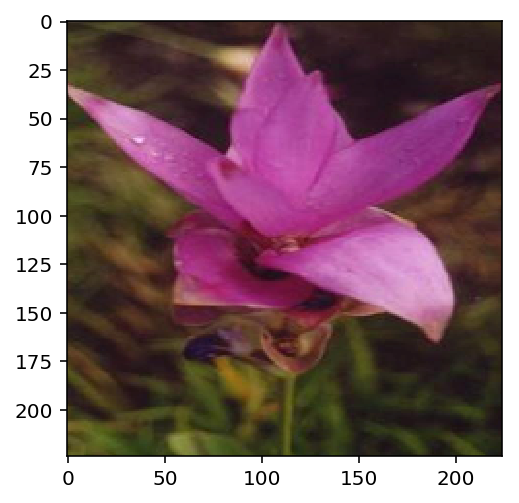

## Class Prediction<a href="#Class-Prediction" class="anchor-link">¶</a>

Once you can get images in the correct format, it's time to write a
function for making predictions with your model. A common practice is to
predict the top 5 or so (usually called top-\$K\$) most probable
classes. You'll want to calculate the class probabilities then find the
\$K\$ largest values.

To get the top \$K\$ largest values in a tensor use
[`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk).
This method returns both the highest `k` probabilities and the indices
of those probabilities corresponding to the classes. You need to convert
from these indices to the actual class labels using `class_to_idx` which
hopefully you added to the model or from an `ImageFolder` you used to
load the data ([see here](#Save-the-checkpoint)). Make sure to invert
the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model
checkpoint, then return the probabilities and classes.

    probs, classes = predict(image_path, model)
    print(probs)
    print(classes)
    > [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
    > ['70', '3', '45', '62', '55']

In \[16\]:

    image_path = '/home/workspace/aipnd-project/flowers/test/1/image_06743.jpg'  
    def predict(image , model):
        
      # Thanks to Constantin Mitides who explained to me what was needed from me in that functionand provided me with       some guidance to fix certain issues with(cpu.detach and floattensor)   
      # Training is off
          model.eval()
          if torch.cuda.is_available():
            
            
            model.cuda()

          image = Image.open(image)
          pill_img = process_image(image)
          image_tensor = torch.cuda.FloatTensor(pill_img)
          image_tensor.unsqueeze_(0)


          ps = torch.exp(model(image_tensor))
          probs, classes = torch.topk(ps,5)

          index_inverted_class = {model.class_to_idx[x]: x for x in model.class_to_idx}

          updated_class = []

          for index in classes.cpu().numpy()[0]:
              updated_class.append(index_inverted_class[index])

          return probs.cpu().detach().numpy()[0], updated_class

## Sanity Checking<a href="#Sanity-Checking" class="anchor-link">¶</a>

Now that you can use a trained model for predictions, check to make sure
it makes sense. Even if the testing accuracy is high, it's always good
to check that there aren't obvious bugs. Use `matplotlib` to plot the
probabilities for the top 5 classes as a bar graph, along with the input
image. It should look like this:

<span class="image"></span>

You can convert from the class integer encoding to actual flower names
with the `cat_to_name.json` file (should have been loaded earlier in the
notebook). To show a PyTorch tensor as an image, use the `imshow`
function defined above.

In \[17\]:

    # Mostly copied from Mnist fashion probability
        
    probs, classes = predict(image_path, model)

    max_index = np.argmax(probs)
    max_probability = probs[max_index]
    label = classes[max_index]

    fig = plt.figure(figsize=(6,6))
    ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
    ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)
    with torch.no_grad():
        
        image = Image.open(image_path)
        ax1.axis('off')
        ax1.set_title(cat_to_name[label])
        ax1.imshow(image)
        labels = []
        for idx in classes:
            labels.append(cat_to_name[idx])
        y_pos = np.arange(5)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(labels)
        ax2.invert_yaxis()  
        ax2.set_xlabel('Probability')
        ax2.barh(y_pos, probs, xerr=0, align='center',color='yellow')

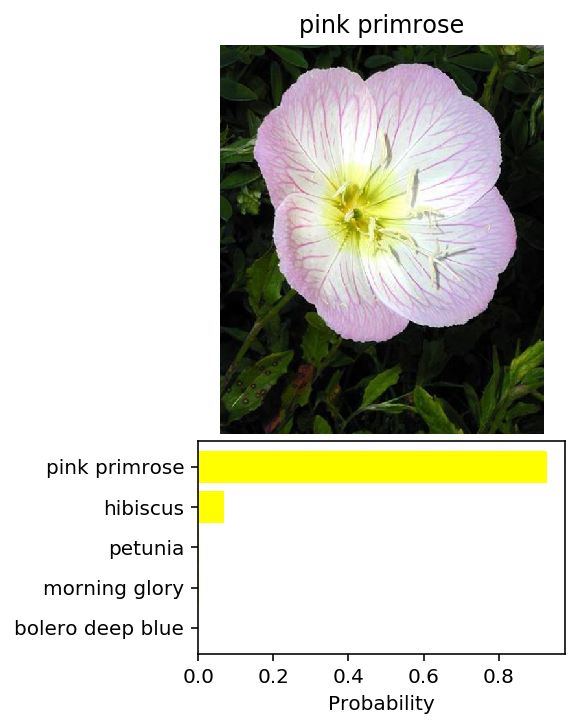